In [1]:
import random
import numpy as np
import tensorflow as tf
import os

def set_global_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_global_seed()

In [3]:
import os

In [4]:
%pwd

'c:\\Users\\rahul\\Desktop\\Sem3\\Pneumonia_detection_cnn\\research'

In [5]:
# Changing the working directory
os.chdir("../")

In [6]:
%pwd

'c:\\Users\\rahul\\Desktop\\Sem3\\Pneumonia_detection_cnn'

# Data Selection

For this project we have choose, Chest X-Ray Images (Pneumonia) data from the Kaggle.

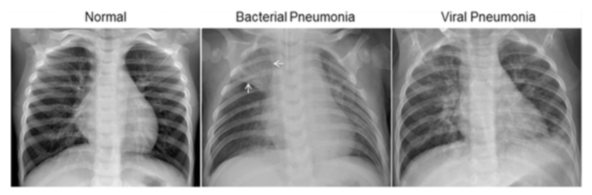

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse "interstitial" pattern in both lungs.

### Downloading the dataset from the kaggle using the `Kagglehub`.

In [7]:
import kagglehub

c:\Users\rahul\Desktop\Sem3\Pneumonia_detection_cnn\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import shutil
from pathlib import Path

In [9]:
dst_path = Path("Data/raw_data")

In [10]:
# Download latest version

if os.path.exists(dst_path):
    print("Data Already exists")
else:
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
    print("Path to dataset files:", path)

Data Already exists


When we use the kagglehub, the dataset is downloaded at a cache path. That's why we moved the dataset to out working directory using the `shutil` package.

In [11]:
if os.path.exists(dst_path):
    print("Data is already present")

else:    
    os.makedirs(dst_path, exist_ok = True)
    shutil.move(src = path,
                dst = dst_path)

Data is already present


# Data Cleaning and Feature Engineering

Checking the Image Shape.

In [7]:
from PIL import Image

In [10]:
img = Image.open(Path("Data/raw_data/2/chest_xray/train/NORMAL/IM-0210-0001.jpeg"))
print(img.size)

(1688, 1105)


Calling the Dataset.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

For training dataset.

Aplying the augmentation on the dataset. Also, the augmentation is always applied on the training dataset

| Parameter            | Description                     |
|----------------------|---------------------------------|
| `rotation_range`     | Rotate image (degrees)          |
| `width_shift_range`  | Shift horizontally              |
| `height_shift_range` | Shift vertically                |
| `shear_range`        | Shearing transformations        |
| `zoom_range`         | Zoom in/out                     |
| `horizontal_flip`    | Flip image horizontally         |
| `fill_mode`          | Fill in new pixels after transform |

All images have been normalized to a pixel range of [0, 1] using the `ImageDataGenerator's` `rescale = 1./255` parameter. This normalization helps speed up convergence during training and ensures that the model processes input features consistently.


In [12]:
# Create an instance of the generator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
    shear_range = 0.1,
    horizontal_flip = True,
    fill_mode = "nearest"
)

# Load images from the directory
train_generator = train_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/train"),
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 5216 images belonging to 2 classes.


For Validation dataset

In [16]:
val_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = val_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/val"),
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 16 images belonging to 2 classes.


For Testing Dataset

In [31]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
    directory = Path("Data/raw_data/2/chest_xray/test"),
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

Found 624 images belonging to 2 classes.


Since we plan to use VGG-16 as part of our transfer learning approach, all images are resized to a shape of (224, 224, 3) to match the input requirements of the model. This resizing ensures compatibility with the pretrained architecture while balancing computational efficiency and performance.

## Data Exploration

Now, checking the class distribution in the training dataset.

In [18]:
from collections import Counter

In [19]:
def print_class_distribution(directory):

    class_counts = {}
    
    for folder in os.listdir(directory):
        class_path = os.path.join(directory, folder)
        
        if os.path.isdir(class_path):
            class_counts[folder] = len(os.listdir(class_path))
    
    print(Counter(class_counts))

    return Counter(class_counts)

In [20]:
counts = print_class_distribution(Path("Data/raw_data/2/chest_xray/train"))

Counter({'PNEUMONIA': 3875, 'NORMAL': 1341})


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

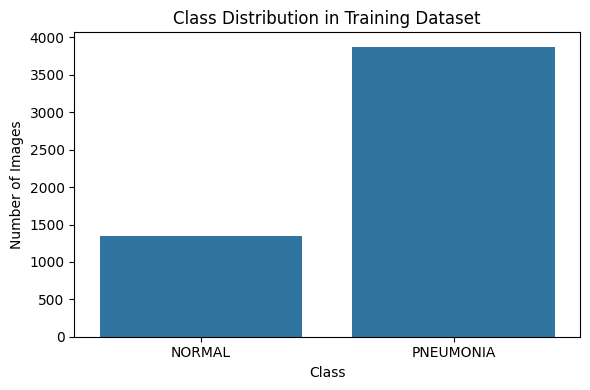

In [22]:
# Function of the visualization of class count
def plot_class_distribution(counts):
    classes = list(counts.keys())
    values = list(counts.values())

    plt.figure(figsize = (6, 4))
    sns.barplot(x = classes, y = values)
    plt.title("Class Distribution in Training Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

# Calling the above made function
plot_class_distribution(counts)


It can be seen that the class imbalance is great in the dataset. We applied `class_weight` in model training which tells the model to "pay more attention" to the minority class by assigning weights.

In [23]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [24]:
classes = ["NORMAL", "PNEUMONIA"]
class_indices = {"NORMAL": 0, "PNEUMONIA": 1}
y = [class_indices["PNEUMONIA"]] * counts.get("PNEUMONIA") + [class_indices["NORMAL"]] * counts.get("NORMAL")

In [25]:
weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y), y = y)

class_weights = {i: weights[i] for i in range(len(weights))}

print(class_weights)

{0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


## Model Selection:

As our task is binary image classification, we have selected a diverse set of models to experiment with. These include traditional machine learning models like :
- Logistic Regression 
- Random Forest Classifier

As well as deep learning approaches like:
- Convolutional Neural Networks (CNN)
- Transfer Learning. 

While traditional models require flattening the image data, CNNs are specifically designed to handle spatial patterns in images, making them particularly well-suited for this task. 

> As previously mentioned, machine learning models such as Logistic Regression and Random Forest Classifier require the dataset to be in a 2D format. Therefore, each image is flattened from its original 3D shape (224×224×3) into a 1D vector, making the input suitable for these models.

#### Machine Learning Models

In [15]:
import joblib

In [16]:
def flatten_data(data_path: Path, generator, data_type: str = "train"):

    flattened_X_path = data_path / f"X_{data_type}_ML_arr.pkl"
    flattened_y_path = data_path / f"y_{data_type}_ML_arr.pkl"

    if os.path.exists(flattened_X_path) and os.path.exists(flattened_y_path):
        print("Data is already flattened")
        print("Loading Data...")

        X_train_flat = joblib.load(flattened_X_path)
        y_train_labels = joblib.load(flattened_y_path)

        print("Data is loaded...")

        return X_train_flat, y_train_labels
    
    else:
        X_train_ML, y_train_ML = [], []

        print("Saving the data in a list...")
        for i in range(len(generator)):
            x_batch, y_batch = generator[i]
            X_train_ML.extend(x_batch)
            y_train_ML.extend(y_batch)

            if (i + 1) * generator.batch_size >= generator.samples:
                break

        print("Data Saved in a list...")
        print("Converting data into numpy array...")
        X_train_ML_arr = np.array(X_train_ML)
        y_train_ML_arr = np.array(y_train_ML)
        print("Data Converted...")

        y_train_labels = np.argmax(y_train_ML_arr, axis=1)
        X_train_flat = X_train_ML_arr.reshape(X_train_ML_arr.shape[0], -1)

        os.makedirs(data_path, exist_ok=True)

        # Save using joblib
        print("Saving the Dataset...")
        joblib.dump(X_train_flat, flattened_X_path)
        joblib.dump(y_train_labels, flattened_y_path)
        print("Dataset Saved...")

        return X_train_flat, y_train_labels

In [28]:
def save_ml_model(**models):
    save_path = Path("Models/ml_models")
    os.makedirs(save_path, exist_ok=True)

    for name, model in models.items():
        file_path = save_path / f"{name}.pkl"
        joblib.dump(model, file_path)
        print(f"Saved {name} to {file_path}")

In [17]:
import joblib
from pathlib import Path
from tensorflow.keras.models import load_model

def load_all_models():
    
    ml_models_path = Path("Models/ml_models")
    tf_models_path = Path("Models/tf_models")

    models = {
        "Logistic Regression": joblib.load(ml_models_path / "logistic_regression.pkl"),
        "Random Forest Classifier": joblib.load(ml_models_path / "rfc_model.pkl"),
        "Deep Convolution Network": load_model(tf_models_path / "best_cnn_model.keras"),
        "VGG-16 (Transfer Learning)": load_model(tf_models_path / "transfer_learning_model.keras")
    }
    return models

In [18]:
x_flattened_data, y_flattened_data = flatten_data(data_path = Path("Data/flattened_data/train"),
                                                  generator = train_generator,
                                                  data_type = "train")

Data is already flattened
Loading Data...
Data is loaded...


In [19]:
x_flattened_data_test, y_flattened_data_test = flatten_data(data_path = Path("Data/flattened_data/test"),
                                                            generator = test_generator,
                                                            data_type = "test")

Data is already flattened
Loading Data...
Data is loaded...


In [21]:
models = load_all_models()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [32]:
# Logistic Regression
log_model = LogisticRegression(max_iter = 1000, class_weight = "balanced")
log_model.fit(x_flattened_data, y_flattened_data)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [33]:
y_pred_log = log_model.predict(x_flattened_data_test)

In [34]:
# Classification report
print("Logistic Regression:")
print(classification_report(y_flattened_data_test, y_pred_log))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       234
           1       0.82      0.83      0.83       390

    accuracy                           0.78       624
   macro avg       0.77      0.77      0.77       624
weighted avg       0.78      0.78      0.78       624



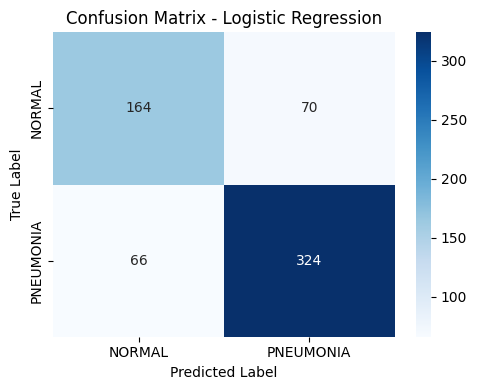

In [35]:
# Confusion matrix
cm = confusion_matrix(y_flattened_data_test, y_pred_log)

# Plotting the confusion matrix
plt.figure(figsize =(5, 4))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["NORMAL", "PNEUMONIA"], yticklabels = ["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()

In [ ]:
# rfc
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth = 10)
rfc_model.fit(x_flattened_data, y_flattened_data)

RandomForestClassifier(max_depth=10)

In [37]:
y_pred_rfc = rfc_model.predict(x_flattened_data_test)

In [38]:
print("Random Forest Classifier:")
print(classification_report(y_flattened_data_test, y_pred_rfc))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       234
           1       0.81      0.96      0.88       390

    accuracy                           0.83       624
   macro avg       0.85      0.79      0.81       624
weighted avg       0.84      0.83      0.83       624



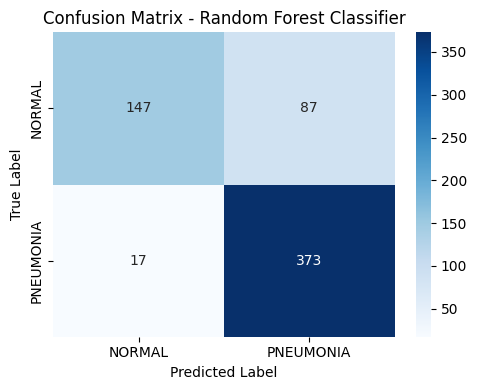

In [39]:
# Confusion matrix
cm = confusion_matrix(y_flattened_data_test, y_pred_rfc)

# Plotting the confusion matrix
plt.figure(figsize =(5, 4))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["NORMAL", "PNEUMONIA"], yticklabels = ["NORMAL", "PNEUMONIA"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest Classifier")
plt.tight_layout()
plt.show()

In [ ]:
model_dict = {
    "logistic_regression": log_model,
    "rfc_model": rfc_model
}

save_ml_model(**model_dict)

#### Deep Learning Models

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [54]:
def build_cnn_model(input_shape = (224, 224, 3), num_classes = 2):
    inputs = Input(shape = input_shape)

    x = Conv2D(32, (3, 3), activation = "relu", padding = "same")(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation = "relu", padding = "same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation = "relu", padding = "same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation = "relu", padding = "same")(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(256, activation = "relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation = "softmax")(x)

    model = Model(inputs, outputs)
    return model

In [66]:
cnn_model = build_cnn_model()

cnn_model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

cnn_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,665,538 (25.43 MB)

 Trainable params: 6,664,834 (25.42 MB)

 Non-trainable params: 704 (2.75 KB)

In [67]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [68]:
# Create a directory to save the best model
checkpoint_dir = Path("Models/tf_models")
checkpoint_dir.mkdir(parents = True, exist_ok = True)

In [69]:
# Define callbacks
early_stop = EarlyStopping(
    monitor = "val_accuracy",
    patience = 3,
    restore_best_weights = True
)

model_checkpoint = ModelCheckpoint(
    filepath = str(checkpoint_dir / "best_cnn_model.keras"),
    monitor = "val_accuracy",
    save_best_only =True
)

In [70]:
cnn_model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [early_stop, model_checkpoint],
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 111s 668ms/step - accuracy: 0.8083 - loss: 0.9157 - val_accuracy: 0.6250 - val_loss: 11.8139
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 668ms/step - accuracy: 0.8700 - loss: 0.3248 - val_accuracy: 0.6250 - val_loss: 5.3094
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 663ms/step - accuracy: 0.8981 - loss: 0.2393 - val_accuracy: 0.6250 - val_loss: 7.2336
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 659ms/step - accuracy: 0.9143 - loss: 0.2274 - val_accuracy: 0.9022 - val_loss: 0.2862
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 107s 659ms/step - accuracy: 0.9220 - loss: 0.1960 - val_accuracy: 0.6266 - val_loss: 3.2128
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 667ms/step - accuracy: 0.9280 - loss: 0.1940 - val_accuracy: 0.6410 - val_loss: 5.2505
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 669ms/step - accuracy: 0.9291 - loss: 0.1879 - val_accuracy: 0.3798 - val_loss: 8.3576


In [22]:
cnn_model = models["Deep Convolution Network"]

In [32]:
# Predict probabilities
predictions = cnn_model.predict(test_generator)

# Convert probabilities to predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

c:\Users\rahul\Desktop\Sem3\Pneumonia_detection_cnn\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step


In [33]:
# True class indices
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

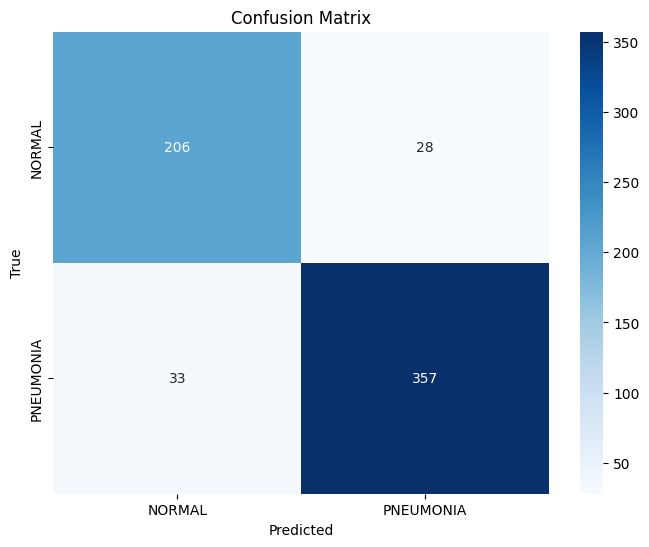

              precision    recall  f1-score   support

      NORMAL       0.86      0.88      0.87       234
   PNEUMONIA       0.93      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.90      0.90       624
weighted avg       0.90      0.90      0.90       624



In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - Deep CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [71]:
from tensorflow.keras.applications import VGG16

In [72]:
# Load VGG16 model without top layer
base_model = VGG16(include_top = False, weights = "imagenet", input_shape = (224, 224, 3))
base_model.trainable = False

In [73]:
# Add custom layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.3)(x)
output = Dense(2, activation = "softmax")(x)

model = Model(inputs = base_model.input, outputs = output)
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [74]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,338 (68.38 MB)

 Trainable params: 3,211,650 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [75]:
# Define callbacks
early_stop_tl = EarlyStopping(
    monitor = "val_accuracy",
    patience = 3,
    restore_best_weights = True
)

model_checkpoint_tl = ModelCheckpoint(
    filepath = str(checkpoint_dir / "transfer_learning_model.keras"),
    monitor = "val_accuracy",
    save_best_only = True
)

In [76]:
model.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 10,
    class_weight = class_weights,
    callbacks = [early_stop_tl, model_checkpoint_tl],
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.8284 - loss: 0.4931 - val_accuracy: 0.8814 - val_loss: 0.2888
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9281 - loss: 0.1842 - val_accuracy: 0.9103 - val_loss: 0.2426
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.9193 - loss: 0.1924 - val_accuracy: 0.9054 - val_loss: 0.2528
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.9353 - loss: 0.1672 - val_accuracy: 0.9167 - val_loss: 0.2394
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.9385 - loss: 0.1561 - val_accuracy: 0.9135 - val_loss: 0.2142
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.9510 - loss: 0.1317 - val_accuracy: 0.9022 - val_loss: 0.2614
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9463 - loss: 0.1453 - val_accuracy: 0.9054 - val_loss: 0.2415


In [35]:
model = models["VGG-16 (Transfer Learning)"]

In [36]:
# Predict probabilities
predictions = model.predict(test_generator)

# Convert probabilities to predicted class indices
predicted_classes = np.argmax(predictions, axis=1)

20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step


In [37]:
# True class indices
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

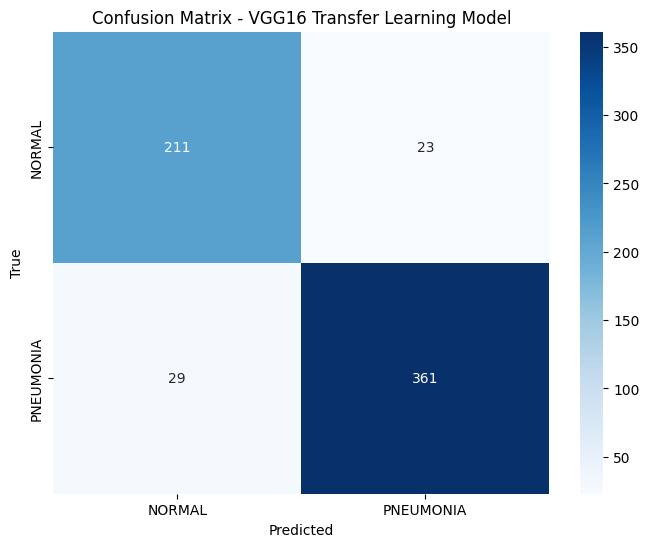

              precision    recall  f1-score   support

      NORMAL       0.88      0.90      0.89       234
   PNEUMONIA       0.94      0.93      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.92      0.92      0.92       624



In [39]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix - VGG16 Transfer Learning Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))